# 第3章 ハンズオンで学ぶ文書分類モデルの作成とツールの利用方法

## 3.1 機械学習モデル開発のワークフローと本章で扱う内容

## 3.2 文書分類ハンズオン

### 3.2.1 本章で扱う主な自然言語処理ツールの解説

#### 3.2.1.1 spaCy

In [ ]:
!pip install -U spacy[cuda]
# pip install -U spacy  # GPUを利用しない場合

In [ ]:
!pip install mecab-python3

In [3]:
import spacy
nlp = spacy.blank('ja')
for word in nlp('すもももももももものうち'):
    print(word)

すもも
も
もも
も
もも
の
うち


#### 3.2.1.2 Transformers

In [ ]:
# 2019年12月現在、NVIDIAのGPUを搭載したLinuxマシンにPyTorchをインストールするコマンドは以下の通りです。
!pip install torch torchvision

In [ ]:
!pip install torchtext

In [ ]:
!pip install transformers

In [ ]:
!pip install pandas scikit-learn tensorboard mojimoji

In [9]:
from transformers import BertJapaneseTokenizer
tokenizer = BertJapaneseTokenizer.from_pretrained('bert-base-japanese-whole-word-masking')
tokenizer.tokenize('いつもプレゼンテーションの撮影に無音カメラアプリをご利用いただきありがとうございます。')

['いつも',
 'プレゼンテーション',
 'の',
 '撮影',
 'に',
 '無',
 '##音',
 'カメラ',
 '##アプリ',
 'を',
 'ご',
 '利用',
 'いただ',
 '##き',
 'ありがとう',
 'ござい',
 'ます',
 '。']

### 3.2.2 データセットの準備

#### 3.2.2.1 livedoor ニュースコーパス

In [10]:
import os
import urllib.request
import tarfile

# dataディレクトリの作成
#os.makedirs('data', exist_ok=True)

url = 'https://www.rondhuit.com/download/ldcc-20140209.tar.gz'
file_name = 'ldcc-20140209.tar.gz'

# dataディレクトリへのlivedoor ニュースコーパスのダウンロードと解凍
if not os.path.exists(file_name):
    urllib.request.urlretrieve(url, file_name)
    # tar.gzファイルを読み込み
    with tarfile.open(file_name) as tar:
        tar.extractall()
    # tar.gzファイルを消去
    os.remove(file_name)

In [11]:
import os
import glob

import pandas as pd

# あまりに短い段落は除く
minimum_sentence_length = 32

# livedoor ニュースのサービス名のリスト
services = [
    'dokujo-tsushin',
    'it-life-hack',
    'kaden-channel',
    'livedoor-homme',
    'movie-enter',
    'peachy',
    'smax',
    'sports-watch',
    'topic-news'
]
# tsvファイルの各カラムのインデックス名のリスト
index = ['url', 'datetime', 'title', 'body']

# 空のPandasのDataFrameを準備
df = pd.DataFrame()

# 各サービスのディレクトリでループ
for service in services:
    print('===== processing {} ====='.format(service))
    # ニュース記事をすべて指定
    # パスの例は './text/dokujo-tsushin/dokujo-tsushin-4778030.txt'
    # LICENSE.txt は除外
    wild_card = os.path.join('text', service, service + '*.txt')
    file_paths = glob.glob(wild_card)
    # 各ニュース記事のファイルパスでループ
    for file_path in file_paths:
        # ファイルを開いて一行ずつ読み込む
        with open(file_path, 'r') as f:
            lines = f.readlines()
            # tsv のカラムを辞書型で用意
            series_dict = {'service': service}
            for num, line in enumerate(lines):
                #line = line.replace('\n', '')  # 改行を削除
                # 0, 1, 2行目はそれぞれURL, 日付, 記事タイトルに相当
                if num < len(index):
                    series_dict[index[num]] = line
                # 3行目以降は本文
                elif line != '\n' and line != '':
                    series_dict['body'] += line
                # lineが空（段落の境目もしくはファイルの末尾）の場合
                else:
                    if '関連記事' in series_dict['body']:
                        pass
                    elif '関連リンク' in series_dict['body']:
                        pass
                    # PandasのSeriesを作成し、DataFrameに追加していく
                    elif len(series_dict['body']) > minimum_sentence_length:
                        s = pd.Series(series_dict)
                        df = df.append(s, ignore_index=True)
                    # bodyを初期化
                    series_dict['body'] = ''
print('done')         

===== processing dokujo-tsushin =====
===== processing it-life-hack =====
===== processing kaden-channel =====
===== processing livedoor-homme =====
===== processing movie-enter =====
===== processing peachy =====
===== processing smax =====
===== processing sports-watch =====
===== processing topic-news =====
done


In [12]:
pd.concat([df.head(3), df.tail(3)])

,body,datetime,service,title,url
0,「しっかりメイクをしている顔よりも、スッピンのほうがいい」と言う男性は少なくない。しかしメイ...,2011-10-13T15:28:00+0900\n,dokujo-tsushin,「スッピンのほうがいい」って本当？——言葉の裏に隠された男の本音\n,http://news.livedoor.com/article/detail/593428...
1,「『スッピンのほうがいい』とは、スッピンでもメイク時と同じくらいかわいい女性が好みだという意...,2011-10-13T15:28:00+0900\n,dokujo-tsushin,「スッピンのほうがいい」って本当？——言葉の裏に隠された男の本音\n,http://news.livedoor.com/article/detail/593428...
2,●「女の子は多少、太ってるくらいがかわいいよ」\n女性は年中、ダイエットと向き合っている。ど...,2011-10-13T15:28:00+0900\n,dokujo-tsushin,「スッピンのほうがいい」って本当？——言葉の裏に隠された男の本音\n,http://news.livedoor.com/article/detail/593428...
56628,藤村修官房長官は20日、記者会見を開き、「政府として軍事転用などという考えは一切持っていない...,2012-06-21T20:32:00+0900\n,topic-news,原子力基本法の改正に、韓国から「日本の核武装を阻止すべき」「我々も核武装だ」の声\n,http://news.livedoor.com/article/detail/668154...
56629,ニュースを受け、韓国のネット掲示板では、「日本は本当に怖い国だ」「日本がするなら我々もする」...,2012-06-21T20:32:00+0900\n,topic-news,原子力基本法の改正に、韓国から「日本の核武装を阻止すべき」「我々も核武装だ」の声\n,http://news.livedoor.com/article/detail/668154...
56630,一方で、「韓国、日本、台湾が全部核武装すれば真の平和が訪れるかもしれない」「各国の健全な良識...,2012-06-21T20:32:00+0900\n,topic-news,原子力基本法の改正に、韓国から「日本の核武装を阻止すべき」「我々も核武装だ」の声\n,http://news.livedoor.com/article/detail/668154...


In [13]:
df['service'].value_counts()

smax              9212
it-life-hack      8400
dokujo-tsushin    8296
peachy            7934
movie-enter       6524
livedoor-homme    5329
kaden-channel     3818
topic-news        3603
sports-watch      3515
Name: service, dtype: int64

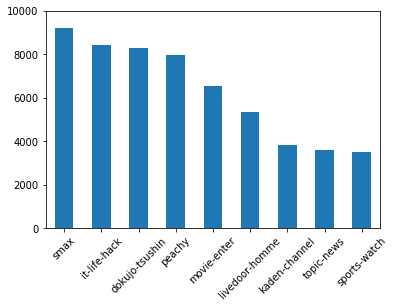

In [14]:
(df['service'].value_counts()).plot(kind='bar', rot=45, ylim=(0, 10000))

In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['service'] = le.fit_transform(df.service.values)
pd.concat([df.head(3), df.tail(3)])  # 最初と最後の3行を抽出

,body,datetime,service,title,url
0,「しっかりメイクをしている顔よりも、スッピンのほうがいい」と言う男性は少なくない。しかしメイ...,2011-10-13T15:28:00+0900\n,0,「スッピンのほうがいい」って本当？——言葉の裏に隠された男の本音\n,http://news.livedoor.com/article/detail/593428...
1,「『スッピンのほうがいい』とは、スッピンでもメイク時と同じくらいかわいい女性が好みだという意...,2011-10-13T15:28:00+0900\n,0,「スッピンのほうがいい」って本当？——言葉の裏に隠された男の本音\n,http://news.livedoor.com/article/detail/593428...
2,●「女の子は多少、太ってるくらいがかわいいよ」\n女性は年中、ダイエットと向き合っている。ど...,2011-10-13T15:28:00+0900\n,0,「スッピンのほうがいい」って本当？——言葉の裏に隠された男の本音\n,http://news.livedoor.com/article/detail/593428...
56628,藤村修官房長官は20日、記者会見を開き、「政府として軍事転用などという考えは一切持っていない...,2012-06-21T20:32:00+0900\n,8,原子力基本法の改正に、韓国から「日本の核武装を阻止すべき」「我々も核武装だ」の声\n,http://news.livedoor.com/article/detail/668154...
56629,ニュースを受け、韓国のネット掲示板では、「日本は本当に怖い国だ」「日本がするなら我々もする」...,2012-06-21T20:32:00+0900\n,8,原子力基本法の改正に、韓国から「日本の核武装を阻止すべき」「我々も核武装だ」の声\n,http://news.livedoor.com/article/detail/668154...
56630,一方で、「韓国、日本、台湾が全部核武装すれば真の平和が訪れるかもしれない」「各国の健全な良識...,2012-06-21T20:32:00+0900\n,8,原子力基本法の改正に、韓国から「日本の核武装を阻止すべき」「我々も核武装だ」の声\n,http://news.livedoor.com/article/detail/668154...


In [16]:
from sklearn.model_selection import train_test_split
df = df[['body', 'service']]  # 本文とラベルのみ抽出
train_df, val_test_df = train_test_split(df, test_size=0.2)
val_df, test_df = train_test_split(val_test_df, test_size=0.5)

In [17]:
train_df.to_csv('train.tsv', sep='\t', index=False)
val_df.to_csv('val.tsv', sep='\t', index=False)
test_df.to_csv('test.tsv', sep='\t', index=False)

### 3.2.3 文書分類モデル

#### 3.2.3.1 単語バッグ  (bag-of-words)

##### データセットの読み込み

In [18]:
import pandas as pd
df_train = pd.read_csv('train.tsv', delimiter='\t')
df_val = pd.read_csv('val.tsv', delimiter='\t')
df_test = pd.read_csv('test.tsv', delimiter='\t')

In [19]:
train_texts = df_train.body
val_texts = df_val.body
test_texts = df_test.body

In [20]:
import spacy
spacy.prefer_gpu()  # GPUがない場合、この行はスキップ
nlp = spacy.blank('ja')

train_docs = list(nlp.pipe(train_texts))
val_docs = list(nlp.pipe(val_texts))
test_docs = list(nlp.pipe(test_texts))

In [21]:
services = [
    'dokujo-tsushin',
    'it-life-hack',
    'kaden-channel',
    'livedoor-homme',
    'movie-enter',
    'peachy',
    'smax',
    'sports-watch',
    'topic-news'
]

train_cats = [{'cats': {service: service == services[idx] for service in services}}
              for idx in df_train.service]
val_cats = [{'cats': {service: service == services[idx] for service in services}}
            for idx in df_val.service]
test_cats = [{'cats': {service: service == services[idx] for service in services}}
             for idx in df_test.service]

In [22]:
print(train_cats[0:2])

[{'cats': {'dokujo-tsushin': False, 'it-life-hack': False, 'kaden-channel': False, 'livedoor-homme': True, 'movie-enter': False, 'peachy': False, 'smax': False, 'sports-watch': False, 'topic-news': False}}, {'cats': {'dokujo-tsushin': False, 'it-life-hack': False, 'kaden-channel': False, 'livedoor-homme': False, 'movie-enter': True, 'peachy': False, 'smax': False, 'sports-watch': False, 'topic-news': False}}]


In [23]:
train_data = list(zip(train_docs, train_cats))
val_data = list(zip(val_docs, val_cats))
test_data = list(zip(test_docs, test_cats))

##### 文書分類モデルの訓練

In [24]:
if 'textcat' not in nlp.pipe_names:
    textcat = nlp.create_pipe('textcat', 
                              config={'exclusive_classes': True, 'architecture': 'bow'})
    nlp.add_pipe(textcat, last=True)  # パイプラインの末尾に追加

In [25]:
for service in services:
    textcat.add_label(service)
    print("Add label %s." % (service))

Add label dokujo-tsushin.
Add label it-life-hack.
Add label kaden-channel.
Add label livedoor-homme.
Add label movie-enter.
Add label peachy.
Add label smax.
Add label sports-watch.
Add label topic-news.


In [26]:
from sklearn.metrics import classification_report

def evaluate(tokenizer, textcat, docs, cats, output_dict=False):
    """訓練時にモデルの性能を評価する関数
    
    引数:
        tokenizer: パイプライン内に含まれるトークナイザー
        textcat: 訓練対象の文書分類モデル
        docs: 評価用データセットのテキストのリスト
        cats: 評価用データセットのラベルのリスト
              e.g. [{'cats': {'dokujo-tsushin': False, ...}}, {'cats': ...}]
    返り値:
        sklearn.metrics.classification_report: 各ラベルに対する性能の表
            (str) if output_dict is False else (dict)
    """
    # Trueのラベルの名前を y_true absのリストに詰める
    # e.g. ['dokujo-tsushin', 'smax', 'peachy', ...]
    y_true = [max(cat['cats'].items(), key=lambda x:x[1])[0] for cat in cats]
    # 一番出力値が大きいラベルの名前を y_pred のリストに詰める
    y_pred = []
    for i, doc in enumerate(textcat.pipe(docs)):
        prediction = max(doc.cats.items(), key=lambda x:x[1])[0]  # 予測のサービス名
        y_pred.append(prediction)
    return classification_report(y_true, y_pred, output_dict=output_dict)

In [ ]:
import random
from tqdm.notebook import tqdm
from spacy.util import minibatch, compounding
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir='./logs/bow/' + datetime.today().isoformat(timespec='seconds'))

# 'textcat' 以外のパイプラインを抽出 (今回は空)
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
# エポック数（何回データセット全体に対してループを回すか）
n_epochs = 32

with nlp.disable_pipes(*other_pipes):  # textcat のみを訓練する
    # >>> nlp.pipeline
    # [('textcat', <spacy.pipeline.pipes.TextCategorizer object at 0x7f62703ee790>)]
    textcat = nlp.pipeline[-1][-1]
    optimizer = textcat.begin_training()
    print('Training the model...')
    # ミニバッチサイズのスケジューリング https://arxiv.org/abs/1711.00489
    batch_sizes = compounding(4.0, 32.0, 1.001)  # サイズ4から始めて上限32まで1.001倍していく
    num_samples = len(train_data)
    for epoch in range(n_epochs):
        print('===== iteration {}/{} ====='.format(epoch+1, n_epochs))
        losses = {}
        # 訓練データをシャッフルしてミニバッチ化する
        random.shuffle(train_data)
        batches = minibatch(train_data, size=batch_sizes)  # generator
        processed = 0
        for batch in tqdm(batches):
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop=0.2, losses=losses)
        # spaCyでは重みの移動平均をトラックしている
        # モデルを利用する際は重みの最新値でなく平均値を利用
        # cf. https://www.aclweb.org/anthology/P04-1015/
        with textcat.model.use_params(optimizer.averages):
            print('val loss = {:.4f}'.format(losses['textcat']))
            # TensorBoard用のログ記録
            writer.add_scalar('Loss vs Epoch/val', losses['textcat'], epoch+1)
            # バリデーションデータに対してモデルを評価する
            report = evaluate(nlp.tokenizer, textcat, val_docs, val_cats, output_dict=True)
            print('val accuracy = {:.4f}'.format(report['accuracy']))
            # TensorBoard用のログ記録
            writer.add_scalar('Accuracy vs Epoch/val', report['accuracy'], epoch+1)

In [ ]:
report = evaluate(nlp.tokenizer, textcat, test_docs, test_cats)
print(report)
# より詳細な値を確認したい場合
#report = evaluate(nlp.tokenizer, textcat, test_docs, test_cats, output_dict=True)
#print('val accuracy is ', report['accuracy'])

In [ ]:
with nlp.use_params(optimizer.averages):
    nlp.to_disk('bow')

In [ ]:
nlp = spacy.load('bow')

In [ ]:
# テストデータ内の livedoor-homme のニュースの一文
doc = nlp('転職者なら誰でも気になる採用する側の心理')
print('true label is livedoor-home ||', doc.cats)
# テストデータ内の smax のニュースの一段落
doc = nlp('ARROWS X F-10Dが7月20日に発売')
print('true label is smax ||', doc.cats)

#### 3.2.3.2 畳み込みニューラルネットワーク

In [ ]:
nlp.remove_pipe('textcat')

In [ ]:
if 'textcat' not in nlp.pipe_names:
    # 今回は 'architecture': 'simple_cnn'
    textcat = nlp.create_pipe('textcat', config={'exclusive_classes': True, 'architecture': 'simple_cnn'})
    nlp.add_pipe(textcat, last=True)

for label in services:
    textcat.add_label(label)
    print('Add label %s.' % (label))

In [ ]:
import random
from tqdm.notebook import tqdm
from spacy.util import minibatch, compounding
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir='./logs/simple_cnn/' + datetime.today().isoformat(timespec='seconds'))

# 'textcat' 以外のパイプラインを抽出 (今回は空)
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
# エポック数（何回データセット全体に対してループを回すか）
n_epochs = 32

with nlp.disable_pipes(*other_pipes):  # textcat のみを訓練する
    # >>> nlp.pipeline
    # [('textcat', <spacy.pipeline.pipes.TextCategorizer object at 0x7f62703ee790>)]
    textcat = nlp.pipeline[-1][-1]
    optimizer = textcat.begin_training()
    print('Training the model...')
    # ミニバッチサイズのスケジューリング https://arxiv.org/abs/1711.00489
    batch_sizes = compounding(4.0, 32.0, 1.001)  # サイズ4から始めて上限32まで1.001倍していく
    num_samples = len(train_data)
    for epoch in range(n_epochs):
        print('===== iteration {}/{} ====='.format(epoch+1, n_epochs))
        losses = {}
        # 訓練データをシャッフルしてミニバッチ化する
        random.shuffle(train_data)
        batches = minibatch(train_data, size=batch_sizes)  # generator
        processed = 0
        for batch in tqdm(batches):
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop=0.2, losses=losses)
        # spaCyでは重みの移動平均をトラックしている
        # モデルを利用する際は重みの最新値でなく平均値を利用
        # cf. https://www.aclweb.org/anthology/P04-1015/
        with textcat.model.use_params(optimizer.averages):
            print('val loss = {:.4f}'.format(losses['textcat']))
            # TensorBoard用のログ記録
            writer.add_scalar('Loss vs Epoch/val', losses['textcat'], epoch+1)
            # バリデーションデータに対してモデルを評価する
            report = evaluate(nlp.tokenizer, textcat, val_docs, val_cats, output_dict=True)
            print('val accuracy = {:.4f}'.format(report['accuracy']))
            # TensorBoard用のログ記録
            writer.add_scalar('Accuracy vs Epoch/val', report['accuracy'], epoch+1)

In [ ]:
report = evaluate(nlp.tokenizer, textcat, test_docs, test_cats)
print(report)
#report = evaluate(nlp.tokenizer, textcat, test_docs, test_cats, output_dict=True)
#print('val accuracy is ', report['accuracy'])

In [ ]:
with nlp.use_params(optimizer.averages):
    nlp.to_disk('simple_cnn')

#### 3.2.3.3 BERT

In [1]:
from transformers import BertForSequenceClassification
net = BertForSequenceClassification.from_pretrained('bert-base-japanese-whole-word-masking', num_labels=9)

##### データの前処理

In [2]:
from transformers import BertJapaneseTokenizer
tokenizer = BertJapaneseTokenizer.from_pretrained('bert-base-japanese-whole-word-masking')

In [3]:
import re
import mojimoji

def tokenizer_with_preprocessing(text):
        # 半角、全角の変換
        text = mojimoji.han_to_zen(text)
        # 改行、半角スペース、全角スペースを削除
        text = re.sub('\r', '', text)
        text = re.sub('\n', '', text)
        text = re.sub('　', '', text)
        text = re.sub(' ', '', text)
        # 数字文字の一律「0」化
        text = re.sub(r'[0-9 ０-９]', '0', text)  # 数字
        return tokenizer.tokenize(text)
    
# 動作確認
text = '私の年収は53万です。'
print(tokenizer_with_preprocessing(text))

['私', 'の', '年', '##収', 'は', '00', '万', 'です', '。']


In [4]:
from torchtext.data import Field

TEXT = Field(
    sequential=True,                        # データの長さが可変か
    tokenize=tokenizer_with_preprocessing,  # トークナイザーの関数の指定
    use_vocab=True,                         # 語彙 (Vocabオブジェクト) を利用するか (後述)
    lower=False,                            # アルファベットを大文字から小文字に変換するか
    include_lengths=True,                   # 各データのトークン数のリストを保持するか
    batch_first=True,                       # データのテンソルの0次元目をミニバッチの次元にするか
    fix_length=512,                         # 全テキストの長さを固定するか (512はbert-japaneseの仕様)
    init_token='[CLS]',                     # 文章の開始を表すトークン
    eos_token='[SEP]',                      # 文章の終了を表すトークン
    pad_token='[PAD]',                      # 長さ調整のパディングに用いるトークン
    unk_token='[UNK]'                       # 未知語を表すトークン
)
LABEL = Field(sequential=False, use_vocab=False)

##### DataSetの読み込み

In [5]:
from torchtext.data import TabularDataset

train, val, test = TabularDataset.splits(
    path='.', train='train.tsv', validation='val.tsv', test='test.tsv', format='tsv', 
    fields=[('body', TEXT), ('service', LABEL)], skip_header=True)

#####  トークンの数値化

In [6]:
import itertools

print(dict(itertools.islice(tokenizer.vocab.items(), 20)))
print('vocab size is', len(tokenizer.vocab))

{'[PAD]': 0, '[UNK]': 1, '[CLS]': 2, '[SEP]': 3, '[MASK]': 4, 'の': 5, '、': 6, 'に': 7, '。': 8, 'は': 9, 'た': 10, 'を': 11, 'で': 12, 'と': 13, 'が': 14, 'し': 15, 'て': 16, '1': 17, 'な': 18, '年': 19}
vocab size is 32000


In [7]:
TEXT.build_vocab(train, min_freq=1)  # 一見無駄なようだが、TEXT.vocabオブジェクトを作るのに必要
TEXT.vocab.stoi = tokenizer.vocab

##### Iteratorの設定

In [9]:
import torch
from torchtext.data import Iterator

batch_size = 32
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_iter = Iterator(train, batch_size, train=True, device=device)
val_iter = Iterator(val, batch_size, train=False, sort=False, device=device)
test_iter = Iterator(test, batch_size, train=False, sort=False, device=device)
# あとで扱いやすいように辞書にまとめておく
iterator_dict = {'train': train_iter, 'val': val_iter, 'test': test_iter}

##### BERTのファインチューニングのための設定

In [10]:
# 1. すべてのパラメーターに対して勾配計算を False にする
for name, param in net.named_parameters():
    param.requires_grad = False
# 2. BertModel の最後のレイヤーのみ勾配計算 True にする
for name, param in net.bert.encoder.layer[-1].named_parameters():
    param.requires_grad = True
# 3. 分類器も勾配計算 True にする
for name, param in net.classifier.named_parameters():
    param.requires_grad = True

In [11]:
# Adamアルゴリズムでそれぞれのパラメータを更新
optimizer = torch.optim.Adam([
    {'params': net.bert.encoder.layer[-1].parameters(), 'lr': 5e-5},
    {'params': net.classifier.parameters(), 'lr': 5e-5}
], betas=(0.9, 0.999))
# 損失関数の設定
criterion = torch.nn.CrossEntropyLoss()

In [12]:
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
#writer = SummaryWriter(log_dir='./logs/bert/' + datetime.today().isoformat(timespec='seconds'))
writer = SummaryWriter(log_dir='./logs/bert/2020-01-07T09:47:00')

def train_model(net, iterator_dict, criterion, optimizer, num_epochs):
    # GPUが使えるかを確認
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    # ネットワークをGPUへ送る
    net.to(device)
    
    # cuDNNのベンチマークモードをオンにして高速化させる
    torch.backends.cudnn.benchmark = True
    
    # ミニバッチサイズ
    batch_size = iterator_dict['train'].batch_size
    
    # ログ用のイタレーション番号
    iteration = 1
    
    # num_epochsだけループ
    for epoch in range(num_epochs):
        # epochごとの訓練とバリデーションのループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードにする
            else:
                net.eval()   # モデルを評価モードにする
                
            epoch_loss = 0.     # epochの損失和
            epoch_corrects = 0  # epochの正解数
            
            # データローダーからミニバッチを取り出すループ
            for batch in iterator_dict[phase]:
                inputs = batch.body[0]  # テキスト
                labels = batch.service  # ラベル
                
                # optimizerの初期化
                optimizer.zero_grad()
                
                # 順伝搬計算
                with torch.set_grad_enabled(phase == 'train'):
                    # 損失とネットワークの出力値を取得
                    loss, outputs = net(input_ids=inputs, labels=labels)
                    # ラベルを予測
                    _, preds = torch.max(outputs, dim=1)
                    # 訓練時は誤差逆伝搬
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                        if (iteration % 10 == 0):  # 10イタレーションに一度ログ出力
                            # ミニバッチの正解率を計算
                            acc = (torch.sum(preds == labels.data)).double() / batch_size
                            print('iteration {} || Loss: {:.4f} || acc {}'.format(
                                iteration, loss.item(), acc.item()))
                            # 損失と正解率をTensorBoardに記録
                            writer.add_scalar("Loss vs Iteration/{}".format(phase), loss.item(), iteration)
                            writer.add_scalar("Accuracy vs Iteration/{}".format(phase), acc.item(), iteration)
                        iteration += 1
                    
                    # epochの損失と正解数の合計を更新
                    epoch_loss += loss.item() * batch_size
                    epoch_corrects += torch.sum(preds == labels.data)
        # epochごとの損失と正解率を計算
        epoch_loss = epoch_loss / len(iterator_dict[phase].dataset)
        epoch_acc = epoch_corrects.double() / len(iterator_dict[phase].dataset)
        # TensorBoardに記録
        writer.add_scalar("Loss vs Epoch/{}".format(phase), epoch_loss, epoch + 1)
        writer.add_scalar("Accuracy vs Epoch/{}".format(phase), epoch_acc, epoch + 1)
        
        print('Epoch {}/{} | {} | Loss: {:.4f} Acc: {:.4f}'.format(
            epoch + 1, num_epochs, phase, epoch_loss, epoch_acc))
    return net

In [ ]:
num_epochs = 32
net_trained = train_model(net, iterator_dict, criterion, optimizer, num_epochs)

In [ ]:
import os

# 訓練したネットワークパラメーターを保存
#save_path = 'bert_trained.pth'
#torch.save(net_trained.state_dics(), save_path)
os.makedirs('./bert', exist_ok=True)
net_trained.save_pretrained('./bert')
# GPUを使えるかどうか
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net_trained.eval()      # モデルを評価モードにする
net_trained.to(device)  # GPUが使えるならGPUに送る

# 正解数
num_corrects = 0

# テストデータに対するループ
for batch in tqdm(iterator_dict['test']):
    inputs = batch.body[0]  # テキスト
    labels = batch.service  # ラベル
    
    # 順伝搬計算
    with torch.set_grad_enabled(False):
        _, outputs = net_trained(input_ids=inputs, labels=labels)
        # ラベルを予測
        _, preds = torch.max(outputs, dim=1)
        # 正解数の合計を更新
        num_corrects += torch.sum(preds == labels.data)
# 正解率を計算
acc = num_corrects.double() / len(iterator_dict['test'].dataset)
print('テストデータ {} 個での正解率: {:.4f}'.format(len(iterator_dict['test'].dataset), acc))

### 3.2.4 評価と比較

## 3.3 まとめ